# Separation-Sufficiency Trade-off Curve (SSC)
## 1. 배경: 기존 지표의 한계 (The Limits of Point-wise Metrics)
머신러닝 공정성(Fairness) 연구에서 가장 널리 논의되는 두 가지 기준은 Separation(분리)/Sufficiency(충분성)입니다. 
하지만 Castelnovo et al.(2022)의 연구에 따르면, 이 두 지표는 특정 조건(기저율 차이 등) 하에서는 수학적으로 양립할 수 없음(Incompatible)이 증명되었다

기존의 공정성 평가는 특정 **임계값(Threshold)** 하나를 고정한 상태에서 단일 수치(Single-point metric)를 확인하는 방식이 주를 이뤘습니다. 
그러나 이는 모델의 전체적인 공정성 잠재력을 평가하지 못하며, 임계값을 임의로 조정함에 따라 공정성 여부가 뒤바뀔 수 있는 **"Threshold Dependency"** 문제를 야기합니다.

## 2. 기존 시각화의 한계: PR Curve (Precision-Recall Curve)
일반적으로 모델 성능 평가에 쓰이는 **PR Curve**는 임계값 변화에 따른 모델의 전반적인 성능(Precision vs Recall)을 보여줍니다. 
하지만 PR Curve는 전체 데이터에 대한 평균적인 성능만을 보여줄 뿐, **그룹 간의 격차(Disparity)**나 **공정성 트레이드오프(Fairness Trade-off)**를 드러내지 못합니다. 
즉, PR Curve의 면적(AUC)이 넓다고 해서 그 모델이 공정하다고 볼 수는 없습니다.

## 3. 제안: SSC (Separation-Sufficiency Curve)
PR Curve의 아이디어를 차용하여, 모델의 **공정성 성능(Fairness Capability)**을 전역적으로 평가할 수 있는 **Separation-Sufficiency Curve (SSC)**를 제안합니다.

* **X축 (Separation Gap):** 그룹 간 FPR(False Positive Rate)의 차이 (Equality of Odds 관점).
* **Y축 (Sufficiency Gap):** 그룹 간 Precision(PPV)의 차이 (Predictive Parity 관점).
* **해석:** 곡선이 원점 $(0,0)$에 가까울수록, 그리고 곡선 아래의 면적(Area)이 작을수록, 해당 모델은 임계값 변화에 덜 민감하게 안정적인 공정성을 유지함을 의미합니다.

이 시각화는 "어떤 임계값을 선택해야 하는가?"를 넘어 "이 모델이 Separation과 Sufficiency 사이의 Inherent Tension을 얼마나 잘 완화하고 있는가?"를 직관적으로 보여줍니다.

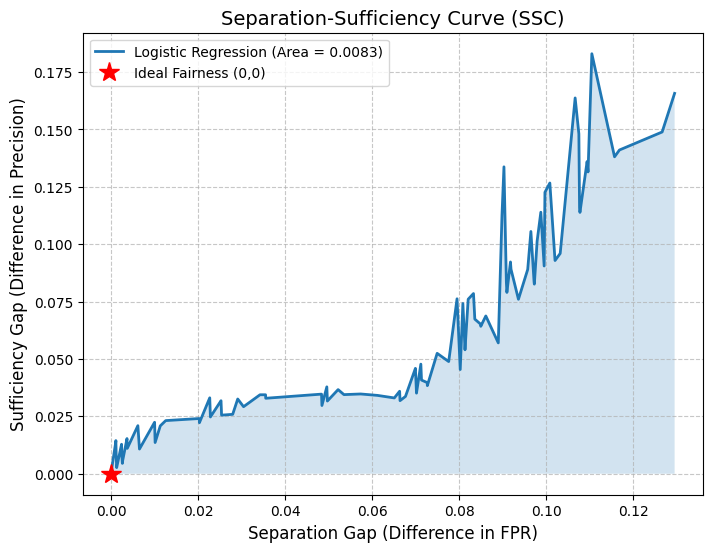

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc
from sklearn.linear_model import LogisticRegression

def calculate_ssc_metrics(y_true, y_score, sensitive_features, num_thresholds=100):
    """
    Separation-Sufficiency Curve를 그리기 위한 Gap들을 계산합니다.
    """
    thresholds = np.linspace(0.01, 0.99, num_thresholds)
    sep_gaps = []  # Separation Gap (FPR difference)
    suff_gaps = [] # Sufficiency Gap (Precision difference)
    valid_thresholds = [] # 유효한 threshold만 저장

    groups = np.unique(sensitive_features)
    if len(groups) != 2:
        raise ValueError("현재 코드는 Binary Sensitive Attribute(두 그룹)만 지원합니다.")

    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        
        group_fprs = {}
        group_precs = {}
        is_valid = True
        
        for g in groups:
            mask = (sensitive_features == g)
            if np.sum(mask) == 0: continue
            
            # Confusion Matrix
            tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0,1]).ravel()
            
            # 1. Separation (FPR): P(Y_hat=1 | Y=0, A=a)
            # 분모(tn+fp)가 0인 경우는 거의 없으나 방어코드 추가
            if (tn + fp) > 0:
                group_fprs[g] = fp / (tn + fp)
            else:
                is_valid = False
            
            # 2. Sufficiency (Precision): P(Y=1 | Y_hat=1, A=a)
            # 모델이 아무것도 1로 예측하지 않으면(tp+fp=0) Precision 정의 불가
            if (tp + fp) > 0:
                group_precs[g] = tp / (tp + fp)
            else:
                is_valid = False
        
        # 두 그룹 모두 지표가 계산되었을 때만 Gap 저장
        if is_valid and len(group_fprs) == 2 and len(group_precs) == 2:
            # 절대값 차이(Gap) 계산
            s_gap = abs(group_fprs[groups[0]] - group_fprs[groups[1]])
            p_gap = abs(group_precs[groups[0]] - group_precs[groups[1]])
            
            sep_gaps.append(s_gap)
            suff_gaps.append(p_gap)
            valid_thresholds.append(t)
            
    return sep_gaps, suff_gaps, valid_thresholds

def plot_ssc(y_true, y_score, sensitive_features, model_name="Model"):
    """
    SSC 곡선을 그리고 면적(Area)을 계산하여 시각화합니다.
    """
    # 1. 메트릭 계산
    sep_gaps, suff_gaps, _ = calculate_ssc_metrics(y_true, y_score, sensitive_features)
    
    # 2. 면적 계산을 위해 X축(Separation Gap) 기준으로 정렬
    # (AUC 함수는 x가 정렬되어 있어야 올바르게 작동함)
    sorted_indices = np.argsort(sep_gaps)
    sep_sorted = np.array(sep_gaps)[sorted_indices]
    suff_sorted = np.array(suff_gaps)[sorted_indices]
    
    # Area 계산 (작을수록 좋음)
    ssc_area = auc(sep_sorted, suff_sorted)
    
    # 3. Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(sep_sorted, suff_sorted, label=f'{model_name} (Area = {ssc_area:.4f})', linewidth=2)
    plt.fill_between(sep_sorted, suff_sorted, alpha=0.2)
    
    # Reference Points
    plt.plot(0, 0, 'r*', markersize=15, label='Ideal Fairness (0,0)')
    
    plt.xlabel('Separation Gap (Difference in FPR)', fontsize=12)
    plt.ylabel('Sufficiency Gap (Difference in Precision)', fontsize=12)
    plt.title('Separation-Sufficiency Curve (SSC)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# --- 실행 예시 (가상 데이터) ---
# 데이터 생성 (이전 대화의 데이터 생성 로직 활용)
np.random.seed(42)
n = 3000
A = np.random.randint(0, 2, size=n)
X = np.random.normal(loc=A, scale=1.5, size=n).reshape(-1, 1) # A에 의존성 높임
logit = 2 * X.flatten() + np.random.normal(0, 1, size=n)
Y = (1 / (1 + np.exp(-logit)) > 0.5).astype(int)

# 모델 학습
clf = LogisticRegression()
clf.fit(X, Y)
scores = clf.predict_proba(X)[:, 1]

# 시각화 실행
plot_ssc(Y, scores, A, model_name="Logistic Regression")

## 4. 해석 및 결론
위 그래프는 모델이 **Separation(오류율의 평등)**과 **Sufficiency(예측값의 신뢰성 평등)** 사이에서 겪는 트레이드오프를 시각화합니다.

1.  **원점(0,0)과의 거리:** 곡선이 원점에서 멀리 떨어져 있을수록, 해당 데이터셋과 모델 구조에서는 두 공정성 지표를 동시에 만족시키기 어렵다는(Incompatible) 것을 의미합니다[cite: 409].
2.  **면적(Area):** 이 면적은 "Threshold 조정만으로는 극복할 수 없는 **구조적 불공정성(Structural Unfairness)**의 총량"으로 해석할 수 있습니다.
    * 면적이 작을수록 모델은 Threshold 변화에 강건(Robust)하게 공정한 성능을 냅니다.
    * 면적이 크다면, Threshold 튜닝보다는 데이터 전처리(Pre-processing)나 모델 규제(In-processing)와 같은 더 근본적인 개입이 필요함을 시사합니다.

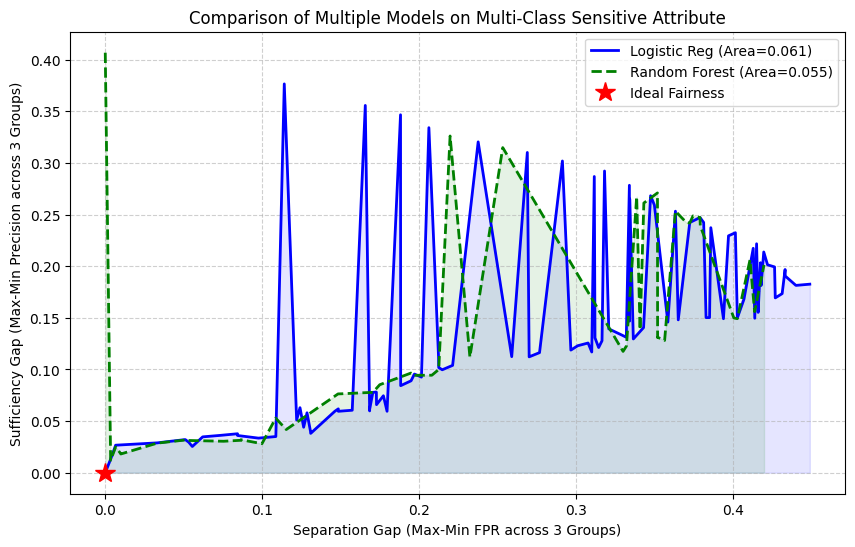

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 1. 다중 속성(Multi-class) 데이터 생성
np.random.seed(42)
n = 3000
# 민감 속성 A가 3개의 그룹 (0, 1, 2)를 가짐
A = np.random.choice([0, 1, 2], size=n, p=[0.3, 0.4, 0.3])

# 데이터 편향 주입: 그룹별로 데이터 분포(평균)가 다름
X = np.random.normal(loc=A, scale=1.2, size=n).reshape(-1, 1)
logits = 1.5 * X.flatten() + np.random.normal(0, 1, size=n)
Y = (1 / (1 + np.exp(-logits)) > 0.5).astype(int)

# 2. 서로 다른 두 모델 학습
# Model A: Logistic Regression (선형)
model_a = LogisticRegression()
model_a.fit(X, Y)
scores_a = model_a.predict_proba(X)[:, 1]

# Model B: Random Forest (비선형)
model_b = RandomForestClassifier(n_estimators=20, max_depth=3, random_state=42)
model_b.fit(X, Y)
scores_b = model_b.predict_proba(X)[:, 1]

# 3. 다중 속성용 Metric 계산 함수 (Max - Min 전략)
def calculate_multiclass_metrics(y_true, y_score, sensitive_features, thresholds):
    sep_gaps, suff_gaps = [], []
    groups = np.unique(sensitive_features) # [0, 1, 2]
    
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        
        group_fprs = []
        group_precs = []
        
        for g in groups:
            mask = (sensitive_features == g)
            if np.sum(mask) == 0: continue
            
            tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0,1]).ravel()
            
            # Separation (FPR)
            if (tn + fp) > 0:
                group_fprs.append(fp / (tn + fp))
            
            # Sufficiency (Precision)
            if (tp + fp) > 0:
                group_precs.append(tp / (tp + fp))
        
        # 그룹이 2개 이상 유효할 때만 Gap 계산
        # Gap = (해당 메트릭의 최대값) - (해당 메트릭의 최소값)
        if len(group_fprs) >= 2 and len(group_precs) >= 2:
            sep_gap = np.max(group_fprs) - np.min(group_fprs)
            suff_gap = np.max(group_precs) - np.min(group_precs)
            sep_gaps.append(sep_gap)
            suff_gaps.append(suff_gap)
            
    return sep_gaps, suff_gaps

# 데이터 정렬 및 Area 계산 헬퍼
def get_plot_data(y_true, y_score, sensitive_features):
    thresholds = np.linspace(0.01, 0.99, 100)
    s, p = calculate_multiclass_metrics(y_true, y_score, sensitive_features, thresholds)
    # X축 기준으로 정렬해야 선이 꼬이지 않음
    idx = np.argsort(s)
    s_sorted, p_sorted = np.array(s)[idx], np.array(p)[idx]
    area = auc(s_sorted, p_sorted)
    return s_sorted, p_sorted, area

# 데이터 준비
sep_a, suff_a, area_a = get_plot_data(Y, scores_a, A)
sep_b, suff_b, area_b = get_plot_data(Y, scores_b, A)

# 4. 비교 시각화
plt.figure(figsize=(10, 6))

# Model A Plot
plt.plot(sep_a, suff_a, 'b-', linewidth=2, label=f'Logistic Reg (Area={area_a:.3f})')
plt.fill_between(sep_a, suff_a, color='blue', alpha=0.1)

# Model B Plot
plt.plot(sep_b, suff_b, 'g--', linewidth=2, label=f'Random Forest (Area={area_b:.3f})')
plt.fill_between(sep_b, suff_b, color='green', alpha=0.1)

plt.xlabel(f'Separation Gap (Max-Min FPR across {len(np.unique(A))} Groups)')
plt.ylabel(f'Sufficiency Gap (Max-Min Precision across {len(np.unique(A))} Groups)')
plt.title('Comparison of Multiple Models on Multi-Class Sensitive Attribute')
plt.plot(0, 0, 'r*', markersize=15, label='Ideal Fairness')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

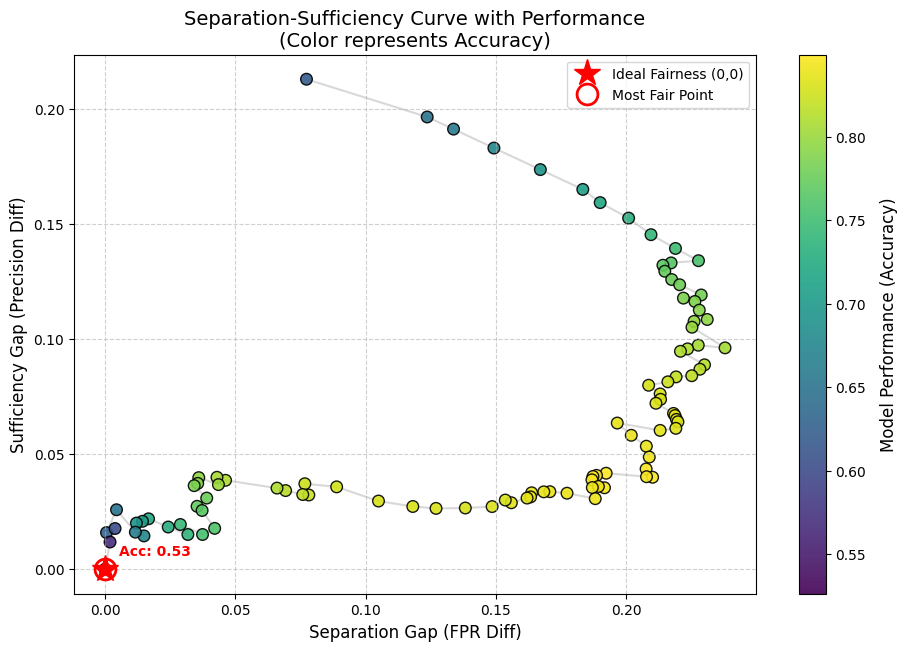

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from matplotlib.collections import LineCollection

# 1. 데이터 생성 및 모델 학습 (이전과 동일한 불균형 상황)
np.random.seed(42)
n = 3000
A = np.random.choice([0, 1], size=n, p=[0.7, 0.3]) # Binary Sensitive Attribute
X = np.random.normal(loc=A, scale=1.2, size=n).reshape(-1, 1) # Bias injection
logits = 1.5 * X.flatten() + np.random.normal(0, 1, size=n)
Y = (1 / (1 + np.exp(-logits)) > 0.5).astype(int)

model = LogisticRegression()
model.fit(X, Y)
scores = model.predict_proba(X)[:, 1]

# 2. 공정성 및 성능 지표 동시 계산 함수
def calculate_metrics_with_performance(y_true, y_score, sensitive_features):
    thresholds = np.linspace(0.01, 0.99, 100)
    
    sep_gaps = []
    suff_gaps = []
    performances = [] # Accuracy or F1
    valid_thresholds = []

    groups = np.unique(sensitive_features)

    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        
        # 성능 지표 (Accuracy) 계산
        acc = accuracy_score(y_true, y_pred)
        # acc = f1_score(y_true, y_pred) # F1을 쓰고 싶다면 교체
        
        group_fprs = []
        group_precs = []
        
        for g in groups:
            mask = (sensitive_features == g)
            if np.sum(mask) == 0: continue
            tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask], labels=[0,1]).ravel()
            
            if (tn+fp) > 0: group_fprs.append(fp/(tn+fp))
            if (tp+fp) > 0: group_precs.append(tp/(tp+fp))
            
        if len(group_fprs) >= 2 and len(group_precs) >= 2:
            sep_gaps.append(max(group_fprs) - min(group_fprs))
            suff_gaps.append(max(group_precs) - min(group_precs))
            performances.append(acc)
            valid_thresholds.append(t)
            
    return sep_gaps, suff_gaps, performances, valid_thresholds

# 데이터 계산
sep, suff, perf, thresholds = calculate_metrics_with_performance(Y, scores, A)

# 3. 시각화 (Scatter Plot with Colorbar)
plt.figure(figsize=(11, 7))

# 산점도로 그리기 (색상 = 성능)
sc = plt.scatter(sep, suff, c=perf, cmap='viridis', s=70, edgecolor='k', alpha=0.9)
# 궤적을 얇은 선으로 연결하여 흐름 파악
plt.plot(sep, suff, color='gray', alpha=0.3, zorder=0)

# Colorbar 설정
cbar = plt.colorbar(sc)
cbar.set_label('Model Performance (Accuracy)', fontsize=12, labelpad=10)

# 이상적 지점 (0,0) 표시
plt.plot(0, 0, 'r*', markersize=20, label='Ideal Fairness (0,0)')

# 최적의 지점 찾기 (예: 거리 + 성능 가중치 고려, 여기서는 단순하게 원점 거리 최소화 지점 표시)
# 공정성 격차의 합(L1 norm)이 가장 작은 지점 중 성능 확인
dists = np.array(sep) + np.array(suff)
best_idx = np.argmin(dists)
plt.plot(sep[best_idx], suff[best_idx], 'ro', markersize=15, fillstyle='none', markeredgewidth=2, label='Most Fair Point')
plt.annotate(f'Acc: {perf[best_idx]:.2f}', (sep[best_idx], suff[best_idx]), 
             xytext=(10, 10), textcoords='offset points', color='red', fontweight='bold')

plt.xlabel('Separation Gap (FPR Diff)', fontsize=12)
plt.ylabel('Sufficiency Gap (Precision Diff)', fontsize=12)
plt.title('Separation-Sufficiency Curve with Performance\n(Color represents Accuracy)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

plt.show()